In [25]:
from models.vgg import vgg13_bn
import torch
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt

Load the model

In [20]:
model = vgg13_bn(pretrained=True)
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

Create a random input

In [21]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#function that preprocesses the image to be as expected by the network
preprocess = transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2471, 0.2435, 0.2616])

# creating an input
mean = 0.5
std = 0.5/3
input = mean + std*torch.randn((3,32,32))
input = preprocess(input)
input = input.to(device)
input_batch = input.unsqueeze(0) # create a mini-batch as expected by the model
input_batch.requires_grad_()




tensor([[[[ 1.3345,  1.0380,  0.6423,  ...,  0.0630, -0.1349,  0.6148],
          [-0.8991, -0.5528, -0.1159,  ...,  1.2790, -0.7642,  0.9680],
          [ 1.0095,  0.6124,  1.5309,  ..., -0.5235,  0.9350,  0.3609],
          ...,
          [ 0.0698, -0.1868, -1.4809,  ...,  1.0167, -0.1986, -0.1428],
          [-0.2672, -0.4568, -0.0736,  ...,  0.3993,  0.3283, -1.4974],
          [-0.0555, -0.0047,  0.1196,  ...,  0.7825,  0.4088,  1.1017]],

         [[-0.7652,  0.7322, -1.0074,  ...,  0.6087,  0.0288,  0.0729],
          [ 0.5407,  0.1459,  0.3129,  ..., -0.6374,  0.0038, -0.5615],
          [ 0.2338,  0.1338, -0.1649,  ..., -0.6832, -0.4683, -0.0748],
          ...,
          [-0.4972, -0.5790, -0.1758,  ..., -0.1632, -0.4257, -0.9507],
          [ 0.5762, -0.1112,  0.3817,  ...,  0.3581,  0.5349,  0.2271],
          [-0.5810, -0.4594,  0.5478,  ...,  0.0502, -0.4934, -0.1681]],

         [[-0.1779,  0.1676,  0.3940,  ..., -0.0059, -0.2666, -0.7577],
          [ 0.3182,  0.0902, -

Helper functions for visualization

In [22]:
def norm_01(array):
    return(array-np.min(array))/(np.max(array)-np.min(array))

def show_im(batch):
    img = batch.reshape(3,32,32).permute(1,2,0)
    img_np = img.detach().numpy()
    plt.imshow(norm_01(img_np))

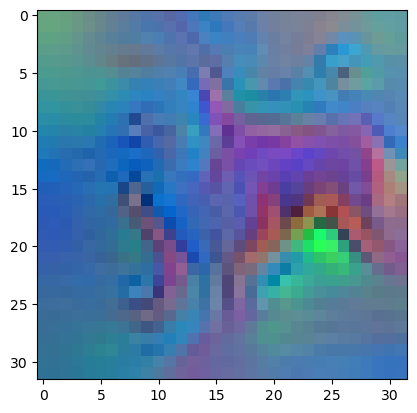

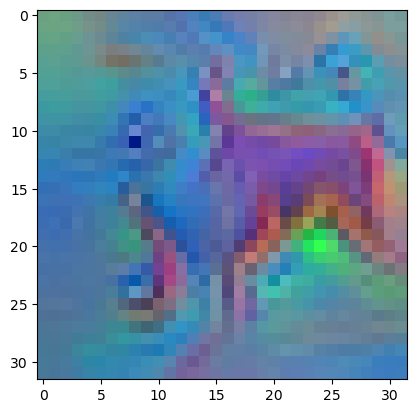

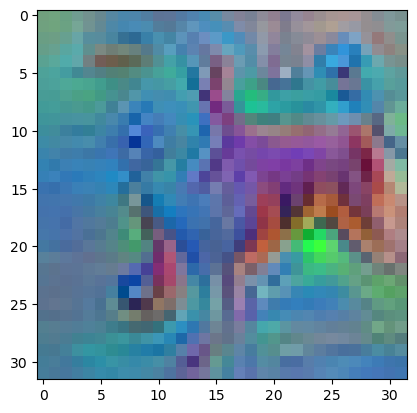

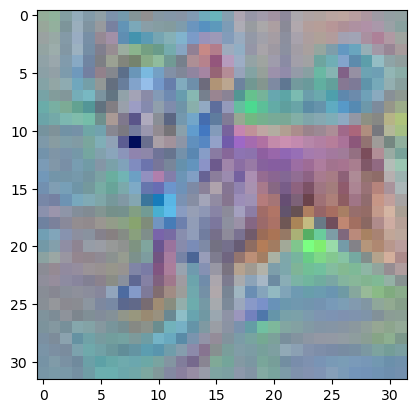

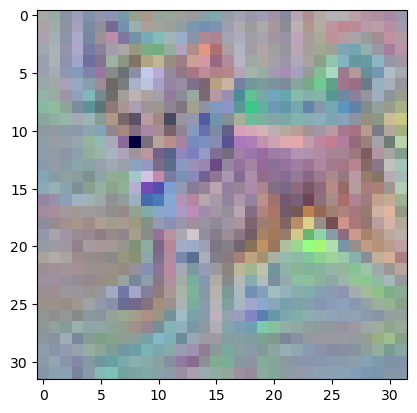

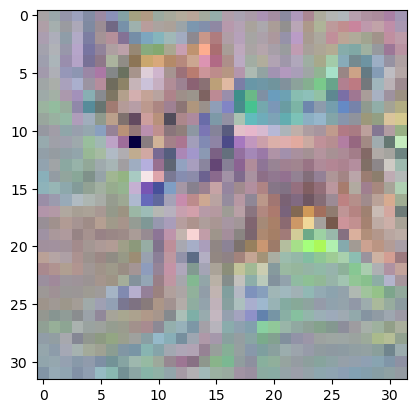

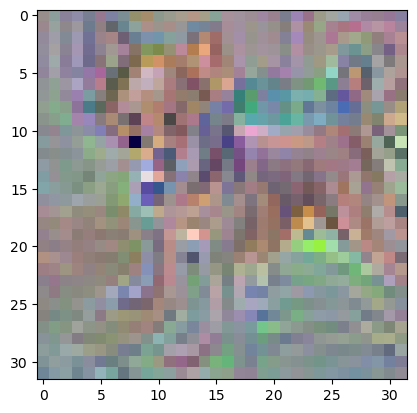

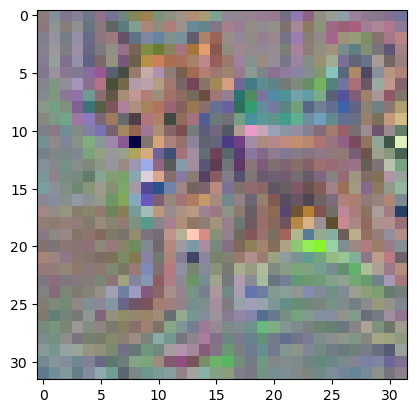

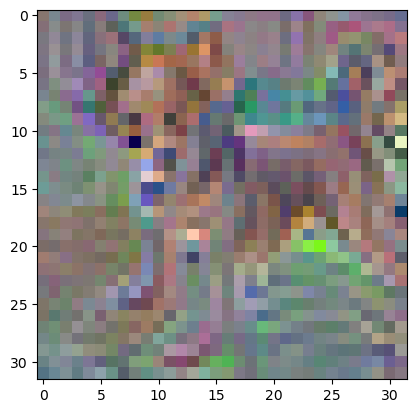

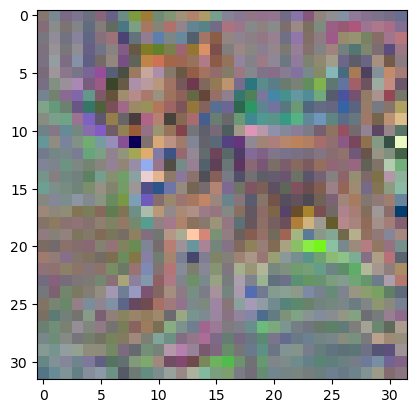

In [24]:
# Class I want to optimize
idx = 5 # 0: airplanes, 1: cars, 2: birds, 3: cats, 4: deer, 5: dogs, 6: frogs, 7: horses, 8: ships, 9: trucks


# Set hyper parameters
epochs = 1000
start_step_size = 0.01
end_step_size = 0.01
start_sig = 0.5 # Sigma of the gaussian kernel
end_sig = 0.1 

# These hyperparameters are not currently used
jitter = 0 
theta_decay = 0.01 

# Number of images you want to visualize
num_im_save = 10
checkpoints = []

# Gradient ascent loop
for epoch in range(epochs):
  
  model.zero_grad()
  if input_batch.grad != None:
    input_batch.grad.zero_()
  y_pred = model.forward(input_batch)

  y_pred[0,idx].backward()

  g = input_batch.grad

  ## Uncomment if you want to experiment with jitter
  # ox, oy = np.random.randint(-jitter, jitter+1, 2)
  
  with torch.no_grad():

    step_size = start_step_size + ((end_step_size - start_step_size) * epoch) / epochs
    input_batch += step_size/np.abs(g).cpu().mean() * g
    
    ## apply jitter shift
    # input_batch = input_batch.roll( ox, -1) 
    # input_batch = input_batch.roll( oy, -2)

    ## Use weight decay
    # input_batch = input_batch.mul((1.0 - theta_decay)) 

    # Use Gaussian blurring
    sig = start_sig + ((end_sig - start_sig) * epoch) / epochs
    blurrer = transforms.GaussianBlur(kernel_size=5, sigma=sig)
    input_batch = blurrer(input_batch)    

  input_batch.requires_grad_()

  if (epoch+1) % (epochs/num_im_save) == 0:
    checkpoints.append(input_batch)
    show_im(input_batch)
    plt.show()

